In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

main_dataset_prepared = pd.read_excel("./buffer/2-main_dataset_prepared.xlsx")
main_dataset_prepared.drop(columns=main_dataset_prepared.columns[0], axis=1, inplace=True)

In [5]:
X = main_dataset_prepared.drop(columns=["Attrition_No", "Attrition_Yes"], axis=1)
y = main_dataset_prepared["Attrition_Yes"]

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=.2,  random_state=0)

## Choix du model

On notes les models selon leurs performances et si les coefficient des parametes d'entrées sont disponibles

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, Perceptron, RidgeClassifier

dict_models = {
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(kernel="linear",  random_state=0),
    "RBF SVM": SVC(random_state=0),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0),
    # "Neural Net": MLPClassifier(random_state=0),
    "AdaBoost": AdaBoostClassifier(random_state=0),
    "Logistic Regression": LogisticRegression(random_state=0),
    "Passive Aggressive Classifier": PassiveAggressiveClassifier(random_state=0),
    "Perceptron": Perceptron(random_state=0),
    "Ridge Classifier": RidgeClassifier(random_state=0)
}

pertinent_model = {}
pertinent_score= {}

for name, model in dict_models.items():
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    pertinent_score[name] = score
    print(f"{name}: {score}  |  ", end='')
    if "coef_" in dir(model) and name != "RBF SVM":
        print("coeff available")
        dict_coef = {}
        for i in range(len(model.coef_[0])):
            dict_coef[model.feature_names_in_[i]] = model.coef_[0][i]
        pertinent_model[name] = dict(sorted(dict_coef.items(),key = lambda kv: kv[1], reverse=True))
    else:
        print("coeff unavailable")

Nearest Neighbors: 0.8696145124716553  |  coeff unavailable
Linear SVM: 0.8356009070294784  |  coeff available
RBF SVM: 0.9126984126984127  |  coeff unavailable
Decision Tree: 0.9773242630385488  |  coeff unavailable
Random Forest: 0.9875283446712018  |  coeff unavailable
AdaBoost: 0.8571428571428571  |  coeff unavailable
Logistic Regression: 0.8469387755102041  |  coeff available
Passive Aggressive Classifier: 0.7993197278911565  |  coeff available
Perceptron: 0.8231292517006803  |  coeff available
Ridge Classifier: 0.854875283446712  |  coeff available


In [8]:
for name in pertinent_model.keys():
    print(f"{name}: {pertinent_score[name]}")

Linear SVM: 0.8356009070294784
Logistic Regression: 0.8469387755102041
Passive Aggressive Classifier: 0.7993197278911565
Perceptron: 0.8231292517006803
Ridge Classifier: 0.854875283446712


## Choix des paramètres

In [9]:
from sklearn.model_selection import GridSearchCV

def GridSearch(param_grid_dict, dict_models):
    bel = {}

    for name, param_grid in param_grid_dict.items():
        model = dict_models[name]
        gs = GridSearchCV(model, param_grid)
        gs.fit(X_train, y_train)
        score = gs.score(X_test, y_test)
        bel[name] = (score, gs.best_params_)

    return bel

In [10]:
param_grid_dict = {
    'Linear SVM': {
        'C': np.arange(0.0001, 0.001, 0.0001),
        'gamma': ['scale'] #, 'auto']
    },
    'Logistic Regression': {
        'penalty': ['l2'], # 'l1', 'l2', 'elasticnet', 'none'],
        'C': [0.15] # np.arange(0.05, 0.3, 0.05)
    },
    'Passive Aggressive Classifier': {
        'C': np.arange(0.0001, 0.001, 0.0001)
    },
    'Perceptron': {
        'penalty': ['l2']#, 'l1', 'elasticnet'],
    },
    'Ridge Classifier': {
        'alpha': np.arange(0.0001, 0.001, 0.0001)
    }
}

In [11]:
best_estimator_list = GridSearch(param_grid_dict, dict_models)

In [12]:
best_estimator_list

{'Linear SVM': (0.8356009070294784, {'C': 0.0001, 'gamma': 'scale'}),
 'Logistic Regression': (0.8503401360544217, {'C': 0.15, 'penalty': 'l2'}),
 'Passive Aggressive Classifier': (0.8356009070294784, {'C': 0.0001}),
 'Perceptron': (0.8401360544217688, {'penalty': 'l2'}),
 'Ridge Classifier': (0.854875283446712, {'alpha': 0.0001})}

In [13]:
coefs = dict_models['Ridge Classifier'].coef_
dict_coef = {X.columns[i]:coefs[0][i] for i in range(len(coefs[0]))}
dict_coef
dict(sorted(dict_coef.items(),key= lambda x:x[1], reverse=True))

{'MaritalStatus_Single': 0.177871022937278,
 'JobRole_Research Director': 0.15911623446805526,
 'BusinessTravel_Travel_Frequently': 0.15457706076457225,
 'Average': 0.1397285725745139,
 'Department_Human Resources': 0.1308144803876125,
 'EducationField_Human Resources': 0.11693258453327932,
 'YearsSinceLastPromotion': 0.07909153252641021,
 'NumCompaniesWorked': 0.07213806537936551,
 'JobRole_Sales Executive': 0.03792465137004308,
 'YearsAtCompany': 0.03347698925471111,
 'JobRole_Research Scientist': 0.027674498312899327,
 'EducationField_Life Sciences': 0.021827837446568014,
 'JobRole_Laboratory Technician': 0.02166170190515564,
 'PercentSalaryHike': 0.017394251805506997,
 'Gender_Male': 0.015001568214782587,
 'JobRole_Human Resources': 0.006987591924915547,
 'Standard deviation': 0.00020049032470554828,
 'nb days off': -0.0011835061443797518,
 'EducationField_Marketing': -0.001493967158085417,
 'DistanceFromHome': -0.0017810975862307368,
 'PerformanceRating': -0.004382629930220473,
 '

Erreur et perte

In [30]:
from sklearn.metrics import mean_squared_error

classifier = RandomForestClassifier()
classifier = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared = False)
print('Root mean squared error : ', rmse)

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print('Mean absolute error :', mae)

from sklearn.metrics import zero_one_loss

print('Zero One Loss : ', zero_one_loss(y_test, y_pred))

TypeError: RandomForestClassifier.__init__() got an unexpected keyword argument 'C'

Matrice de confusion

In [27]:
from sklearn.metrics import confusion_matrix

print(pd.DataFrame(confusion_matrix(y_test, y_pred), columns= ['predicted_No', 'predicted_Yes'], index=['actual_No', 'actual_Yes']))

            predicted_No  predicted_Yes
actual_No            714             23
actual_Yes           109             36


C:\Users\Sevket\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


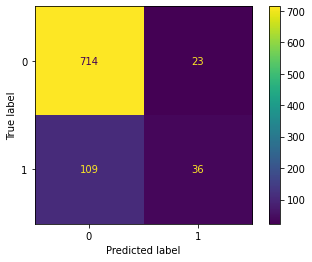

In [28]:
from sklearn import metrics 

metrics.plot_confusion_matrix(classifier, X_test, y_test)  
plt.show()

In [29]:
from sklearn.metrics import precision_score, recall_score, average_precision_score, f1_score, fbeta_score

#Score of our classifier
clf_score = classifier.score(X_test, y_test)
print('Classifier Score :', clf_score)

#Precision of our score
print('Precision Score :', precision_score(y_test, y_pred))

# Recall of our score
print('Recall Score : ', recall_score(y_test, y_pred))

# Score of the average precision
print('Average Precision Score : ', average_precision_score(y_test, y_pred))

# F1 Score
print('F1 Score : ', f1_score(y_test, y_pred))

# F Beta Score
print('F Beta Score : ', fbeta_score(y_test, y_pred, beta= 0.5))

Classifier Score : 0.8503401360544217
Precision Score : 0.6101694915254238
Recall Score :  0.2482758620689655
Average Precision Score :  0.2750731229565662
F1 Score :  0.35294117647058826
F Beta Score :  0.47244094488188987


In [ ]:
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score

